In [1]:
import warnings

warnings.filterwarnings('ignore')

# 2 模仿过程

## 2.1 过程分解

- **数据准备**

In [2]:
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
from shapely.geometry import Point

# 读入旧金山社区面数据
sf = gpd.read_file('zip://SF Find Neighborhoods.zip')

# 读入街道树木位置点数据并进行矢量化
trees = pd.read_csv('sf_trees.csv')

tqdm.pandas()
# 基于经纬度为trees添加矢量列并转为GeoDataFrame
trees['geometry'] = trees.progress_apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
trees = gpd.GeoDataFrame(trees, crs='EPSG:4326')

In [3]:
import osmnx as ox
from shapely.geometry import box

# 基于社区面bbox范围进行路网获取
G = ox.graph_from_polygon(box(*sf.total_bounds))
roads = ox.graph_to_gdfs(G)[1] # 第0个位置返回的GeoDataFrame是节点数据我们不需要
roads.head()

,osmid,highway,oneway,length,lanes,ref,name,maxspeed,bridge,geometry,service,access,junction,tunnel,width,u,v,key
0,396123635,footway,False,9.371,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-122.37459 37.70854, -122.37459 37...",NaN,NaN,NaN,NaN,NaN,31843591,364491481,0
1,"[50690291, 179235221, 661905446]",motorway,True,3232.712,5,I 80,San Francisco – Oakland Bay Bridge,50 mph,yes,"LINESTRING (-122.39094 37.78592, -122.39068 37...",NaN,NaN,NaN,NaN,NaN,32927563,645559609,0
2,28715659,motorway_link,True,333.165,1,NaN,NaN,NaN,NaN,"LINESTRING (-122.42412 37.73135, -122.42362 37...",NaN,NaN,NaN,NaN,NaN,32927591,315706881,0
3,689603997,motorway,True,794.493,4,I 280,John F Foran Freeway,65 mph,NaN,"LINESTRING (-122.42412 37.73135, -122.42396 37...",NaN,NaN,NaN,NaN,NaN,32927591,6469349533,0
4,"[28846637, 8918870, 61424023]",motorway,True,1196.665,2,I 280,Southern Embarcadero Freeway,65 mph,yes,"LINESTRING (-122.41326 37.73271, -122.41224 37...",NaN,NaN,NaN,NaN,NaN,32927645,65331336,0


In [4]:
# 统计每个社区内部的树木数量
sf_trees = \
(
    gpd
    # 空间连接
    .sjoin(left_df=sf,
           right_df=trees,
           op='contains',
           how='left')
    # 按照name分组计数（这里未连接到任何数的社区被
    # 记为1本质上是错误的，但我们绘图分段后这一点不影响）
    .groupby('name')
    .agg({
        'name': 'count',
        'geometry': 'first'
    })
    .rename(columns={'name': '数量'})
    .reset_index(drop=False)
    # 直接转为GeoDataFrame
    .pipe(gpd.GeoDataFrame, crs='EPSG:4326')
)

sf_trees['颜色'] = (
    pd
    .cut(sf_trees['数量'], 
         bins=[0, 2500, 5000, 7500, 10000, max(sf_trees['数量'])], 
         labels=['#e4f1e1', '#c0dfd1', '#67a9a2', '#3b8383', '#145e64'])
)

In [5]:
# 生成轮廓缓冲区
sf_bounds = gpd.GeoSeries([sf.buffer(0.001).unary_union], crs='EPSG:4326')

- **主要视觉元素绘制**

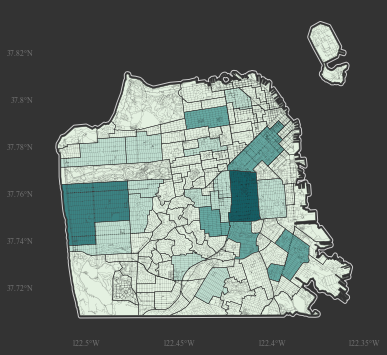

In [6]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 设置全局默认字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']

fig, ax = plt.subplots(figsize=(6, 6))

# 设置背景色
ax.set_facecolor('#333333')
fig.set_facecolor('#333333')

# 图层1：缓冲区轮廓
ax = (
    sf_bounds
    .plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=1)
)

# 图层2：带有树木统计信息的社区面
ax = (
    sf_trees
    .plot(color=sf_trees['颜色'], edgecolor='#333333',
          linewidth=0.5, ax=ax)
)

# 图层3：osm路网
ax = (
    roads
    .plot(linewidth=0.05, edgecolor='#3c3d3d',
          ax=ax)
)

# 设置x轴
ax.set_xticks([-122.5, -122.45, -122.4, -122.35])
ax.set_xticklabels(['122.5°W', '122.45°W', '122.4°W', '122.35°W'])

# 设置y轴
ax.set_yticks([37.72, 37.74, 37.76, 37.78, 37.8, 37.82])
ax.set_yticklabels(['37.72°N', '37.74°N', '37.76°N', '37.78°N', '37.8°N', '37.82°N'])

# 设置坐标轴样式
ax.tick_params(axis='both', labelcolor='#737373', color='none', labelsize=8)

# 隐藏周围的spines线条
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')

# 导出图像
fig.savefig('图4.png', dpi=600, bbox_inches='tight')

- **辅助视觉元素的添加**

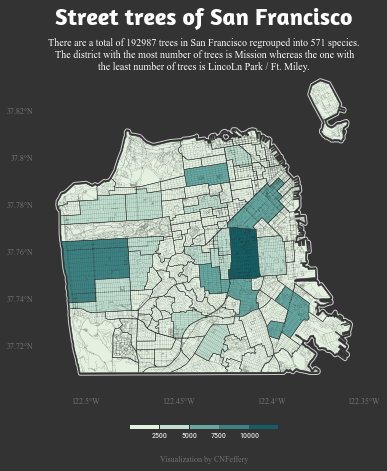

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

# 设置背景色
ax.set_facecolor('#333333')
fig.set_facecolor('#333333')

# 图层1：缓冲区轮廓
ax = (
    sf_bounds
    .plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=1)
)

# 图层2：带有树木统计信息的社区面
ax = (
    sf_trees
    .plot(color=sf_trees['颜色'], edgecolor='#333333',
          linewidth=0.5, ax=ax)
)

# 图层3：osm路网
ax = (
    roads
    .plot(linewidth=0.05, edgecolor='#3c3d3d',
          ax=ax)
)

# 设置x轴
ax.set_xticks([-122.5, -122.45, -122.4, -122.35])
ax.set_xticklabels(['122.5°W', '122.45°W', '122.4°W', '122.35°W'])

# 设置y轴
ax.set_yticks([37.72, 37.74, 37.76, 37.78, 37.8, 37.82])
ax.set_yticklabels(['37.72°N', '37.74°N', '37.76°N', '37.78°N', '37.8°N', '37.82°N'])

# 设置坐标轴样式
ax.tick_params(axis='both', labelcolor='#737373', color='none', labelsize=8)

# 隐藏周围的spines线条
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')

# 以插入子图的方式添加下方图例
ax_bar = ax.inset_axes((0.25, -0.12, 0.5, 0.015))
ax_bar.set_facecolor('#333333')
ax_bar.spines['left'].set_color('none')
ax_bar.spines['right'].set_color('none')
ax_bar.spines['top'].set_color('none')
ax_bar.spines['bottom'].set_color('none')

ax_bar.bar(range(5), [1]*5, width=0.975, color=['#e4f1e1', '#c0dfd1', '#67a9a2', '#3b8383', '#145e64'])
ax_bar.set_yticks([])
ax_bar.set_xticks([i+0.5 for i in range(4)])
ax_bar.set_xticklabels(['2500', '5000', '7500', '10000'], 
                       fontdict={'fontproperties': fm.FontProperties(fname="RobotoCondensed-Regular.ttf")})
ax_bar.tick_params(color='none', labelcolor='#ffffff', labelsize=8, pad=0)

ax.set_title('Street trees of San Francisco', 
             fontsize=24,
             color='#ffffff',
             pad=40,
             fontproperties=fm.FontProperties(fname="Amaranth-Bold.ttf"))

ax.text(0.5, 1.08, '''There are a total of 192987 trees in San Francisco regrouped into 571 species.
The district with the most number of trees is Mission whereas the one with
the least number of trees is LincoLn Park / Ft. Miley.''', transform=ax.transAxes, ma='center',
        ha='center', va='top', color='#ffffff')

ax.text(0.5, -0.22, 'Visualization by CNFeffery', fontsize=8,
        color='#737373', ha='center', transform=ax.transAxes)

# 导出图像
fig.savefig('图5.png', dpi=600, bbox_inches='tight')